# Covid-19 Situation in San Diego
I keep checking [San Diego County's Covid-19 webpage](https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html) for up-to-date stats. I'm interested in the number of new cases per day, since that's what tells us if Covid-19 is spreading at an exponential rate (which would be _really_ scary – see [Simulating an epidemic](https://www.youtube.com/watch?v=gxAaO2rsdIs) by Grant Sanderson of 3blue1brown). The county website has new cases per day already, so perfect, right? The thing is, if you check the number of new _tests_ by day, you'll see that it looks awfully like the number of new cases per day. Now what I'm wondering is whether the new cases per day is indicative of _actual_ new cases or only the number of tests.

First let's get the data.

In [1]:
import requests
import datetime
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

figsize = (15, 3)

We can find the query URL [here](https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county?orderBy=date&orderByAsc=false&selectedAttribute=tests). SANDAG has some amazing datasets with great documentation by the way. I'd highly suggest anyone interested in Data Science who lives in the San Diego area to go check out the other data sets they have.

In [2]:
query_url = 'https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID_19_Statistics_San_Diego_County/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
response = requests.get(query_url)

if response.status_code == 200:
    print('Successfully ran API query')

Successfully ran API query


In [3]:
response.json().keys()

dict_keys(['exceededTransferLimit', 'features', 'fields', 'geometryType', 'spatialReference', 'globalIdFieldName', 'objectIdFieldName', 'hasZ', 'hasM'])

Alright, most of those are just extra metadata. What we care about is in `features`.

In [4]:
len(response.json()['features'])

89

We have one entry per day since mid-March when California started quarantining.

In [5]:
# we're working with such a small dataset that we don't have to worry about computation time.
# It'd probably take me longer to optimize than the time I'd save optimizing.
example = response.json()['features'][0]
cols = example['attributes'].keys()
df = pd.DataFrame(columns=cols)

for feature in response.json()['features']:
    df = df.append(pd.Series(feature['attributes']), ignore_index=True)

#df.set_index('objectid', inplace=True)
df.sort_values('date', inplace=True)

df.head()

,objectid,date,tests,positives,hospitalized,icu,deaths,newcases,age_9,age10_19,...,age80_plus,ageunknow,age20_29,genderfemale,gendermale,gendeunk,age30_39,globalid,newtests,rolling_perc_pos_cases
31,87,1583568000000,None,1,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{CE98E5A7-7D8E-4D20-BC84-069A17D43232},None,None
32,88,1583654400000,None,2,0,0,0,1,None,None,...,None,None,None,None,None,None,None,{8AC07123-E9DA-4D83-9720-7BF93E4B6C44},None,None
33,89,1583740800000,None,2,0,0,0,0,None,None,...,None,None,None,None,None,None,None,{52083240-452D-41A6-BD0F-2D424B2745BC},None,None
34,90,1583827200000,None,4,0,0,0,2,None,None,...,None,None,None,None,None,None,None,{9DF87361-2D53-4A06-8DF9-A986B660061D},None,None
3,59,1583913600000,123,5,None,None,None,1,None,None,...,None,None,None,None,None,None,None,{78698F35-A6E9-48CB-8C8D-67A70EC15C1D},None,None


Alright, data is there, but not exactly in the format we want.

First, let's convert the date from an integer to a datetime. I'm not completely familiar with ARCGIS data but the metadata says this is of type esriFieldTypeDate with length 29. A [post on StackOverflow](https://stackoverflow.com/questions/17231711/how-to-create-datetime-from-a-negative-epoch-in-python/17231712) shows us how to convert this into a datetime object.

In [6]:
df['date'] = df['date'].apply(lambda x: datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(x/1000)))
df['date_str'] = df['date'].dt.strftime('%m/%d')
df.sort_values('date', inplace=True)

We also want to today's deaths - not just the total.

In [7]:
df.deaths.fillna(0, inplace=True)
df['deaths_today'] = df['deaths'] - df.shift(periods=1)['deaths']

We'll also want a way to make nice plots without writing the same code over and over.

In [8]:
def plot_by_time(col):
    df.set_index('date_str')[col].plot.bar(figsize=figsize, rot=70)
    plt.xlabel('Date')

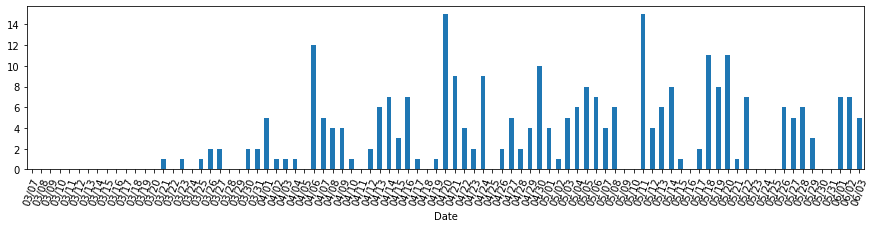

In [9]:
plot_by_time('deaths_today')

And we want the total number of cases to date:

In [10]:
df['reported_new_cases'] = df['newcases'] # make new column with more accurate name
df['total_cases_reported'] = df['reported_new_cases'].cumsum()

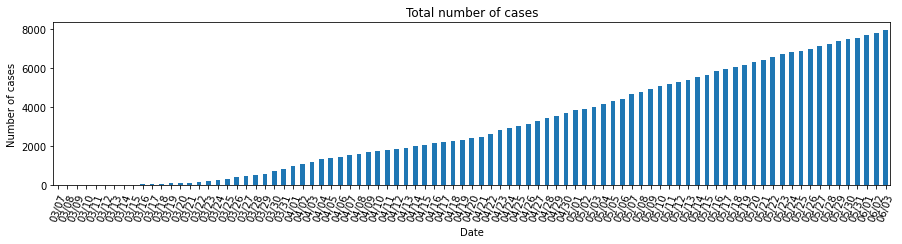

In [11]:
plot_by_time(col='total_cases_reported')
plt.title('Total number of cases')
plt.ylabel('Number of cases');

Finally, we'll want to fill in some missing values. Since these are all at the beginning of the timeline, it's safe to say there was no testing and we can just fill with 0.

In [12]:
df['newtests'] = df['newtests'].fillna(0)

In [13]:
df.head()

,objectid,date,tests,positives,hospitalized,icu,deaths,newcases,age_9,age10_19,...,gendermale,gendeunk,age30_39,globalid,newtests,rolling_perc_pos_cases,date_str,deaths_today,reported_new_cases,total_cases_reported
31,87,2020-03-07 08:00:00,None,1,0,0,0,1,None,None,...,None,None,None,{CE98E5A7-7D8E-4D20-BC84-069A17D43232},0,None,03/07,NaN,1,1
32,88,2020-03-08 08:00:00,None,2,0,0,0,1,None,None,...,None,None,None,{8AC07123-E9DA-4D83-9720-7BF93E4B6C44},0,None,03/08,0.0,1,2
33,89,2020-03-09 08:00:00,None,2,0,0,0,0,None,None,...,None,None,None,{52083240-452D-41A6-BD0F-2D424B2745BC},0,None,03/09,0.0,0,2
34,90,2020-03-10 08:00:00,None,4,0,0,0,2,None,None,...,None,None,None,{9DF87361-2D53-4A06-8DF9-A986B660061D},0,None,03/10,0.0,2,4
3,59,2020-03-11 08:00:00,123,5,None,None,0,1,None,None,...,None,None,None,{78698F35-A6E9-48CB-8C8D-67A70EC15C1D},0,None,03/11,0.0,1,5


Okay, now that we have the data in the format we want it, let's try our first approach. Let's just overlay the two graphs:

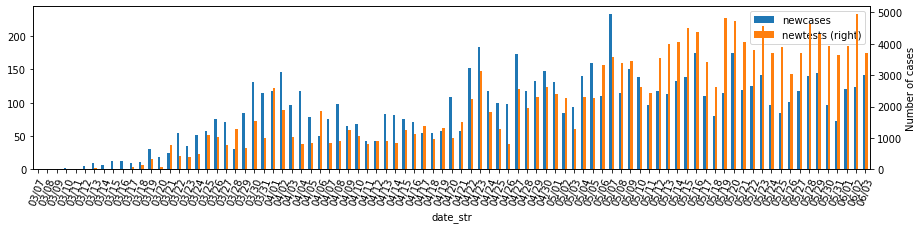

In [14]:
df.set_index('date_str')[['newcases', 'newtests']].plot.bar(figsize=figsize, secondary_y= 'newtests', rot=70)
plt.ylabel('Number of cases')
plt.xlabel('Date');

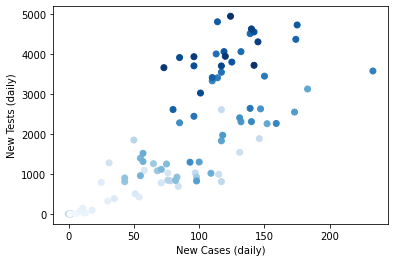

In [15]:
plt.scatter(df['newcases'].values, df['newtests'].values, c=df['objectid']/df['objectid'].max(), cmap='Blues')
plt.ylabel('New Tests (daily)')
plt.xlabel('New Cases (daily)');

In [16]:
stats.spearmanr(df['newcases'].values, df['newtests'].values)

SpearmanrResult(correlation=0.7932612688243987, pvalue=1.9188092884390598e-20)

Both of the plots as well as the Spearman R definitely show there's a correlation, which makes sense. Since we can't just test everyone, we're only testing the people that are actually likely to have the disease.  
  
This means that we can't just focus on the reported numbers, since there's a possibility they're just telling us the number of tests. This is nice because in some way it frees us from having to worry about the number going up or down today. If the number goes up, that might actually be a _good_ thing - it could mean we're testing more people.   
  
But now that we know the reported cases, we know we can't rely upon reported cases as an accurate measure of actual cases. And we need this information to know whether the actual number of cases is going up or down. Now, how can we get a better estimate?

## Estimate current actual cases by number of deaths
As explained by Tomas Pueyo in his [brilliant Medium article](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca) and later by [Salman Khan himself](https://www.youtube.com/watch?v=mCa0JXEwDEk), we can calculate an estimate for the actual number of cases using a roundabout method based on more accurately reported numbers.

The first thing we need is the doubling time. That is, the number of days until the number of cases doubles from what it is currently. In Khan's example, he only calculated the value once, but we want to calculate it for many days. It's reasonable to think that it will change since it depends on all kinds of things like public policy and how many people are adhering to social distancing guidelines, and these things change significantly as public opinion changes. 

For one pair of days we can use a formula from the [Doubling Time wiki page](https://en.wikipedia.org/wiki/Doubling_time).

In [17]:
# test out our formula - we should get a doubling rate of 1 day
q1 = 100
q2 = 200
time_delta = 1 # days

time_delta * np.log(2) / np.log(q2/q1)

1.0

Notice that this will change based on how many days apart we sample the two days. Let's take a look at our doubling rate for different sampling spacings.

<ipython-input-18-52747ccf5749>:3: RuntimeWarning: divide by zero encountered in true_divide
  df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df['total_cases_reported'], dtype=float) /


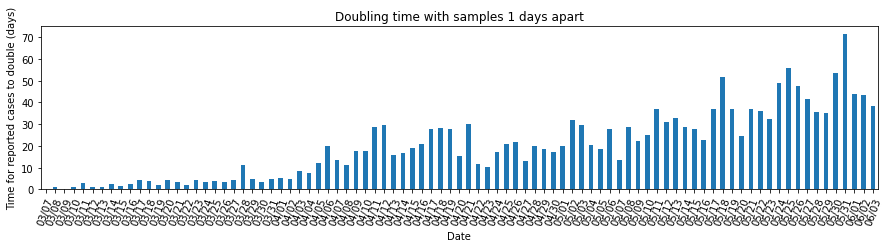

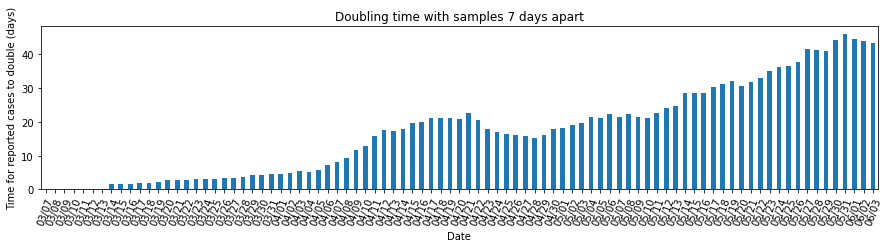

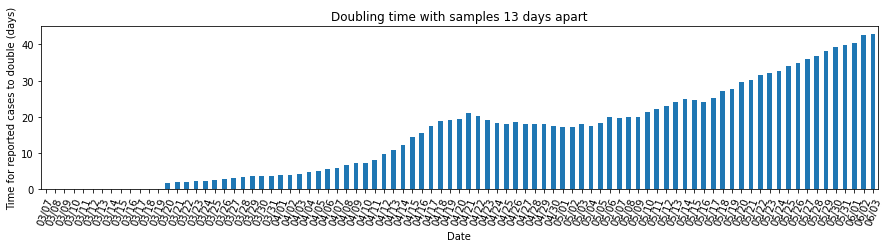

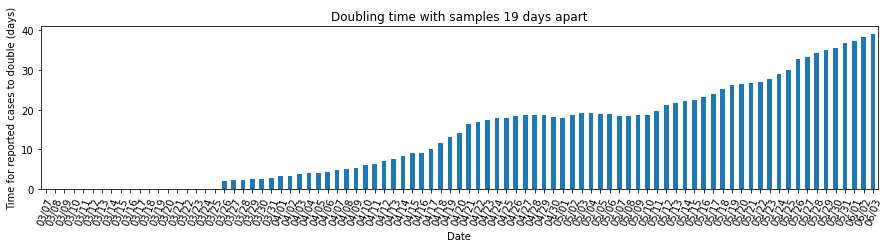

In [18]:
for i in range(1, 20, 6):
    time_delta = i # days
    df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df['total_cases_reported'], dtype=float) / 
                                                           np.array(df.shift(periods=time_delta)['total_cases_reported'], dtype=float))
    
    plt.figure()
    plt.title(f'Doubling time with samples {i} days apart')
    plot_by_time('days_to_double')
    plt.ylabel('Time for reported cases to double (days)')
    plt.xlabel('Date');

Increasing the time between samples for calculating doubling rate smooths out the noise of individual days, but also pushes back the earliest time we can make an inference about. I've chosen a time of 7 days so we have a smoother curve without sacrificing very much of the earlier data.  
Today's doubling time (May 21) is fairly close to the County's reported time of 34 days.

In [19]:
time_delta = 7 # days
df['days_to_double'] = time_delta * np.log(2) / np.log(np.array(df['total_cases_reported'], dtype=float) / 
                                                       np.array(df.shift(periods=time_delta)['total_cases_reported'], dtype=float))

So now that we have the doubling rate for each day, we can make some assumptions for the remaining pieces needed.

In [20]:
mortality_rate = 0.01 # 1%
infection_to_death_time = 20 # days

In [21]:
# example for May 21, 2020
total_deaths = 242
doubling_time_days = 34

estimated_cases_20_days_ago = total_deaths / mortality_rate
number_of_times_doubled = infection_to_death_time / doubling_time_days
cases_estimate_by_deaths = np.exp2(number_of_times_doubled) * estimated_cases_20_days_ago

print(f'If there were {total_deaths} deaths up until now, then that would mean there were {int(estimated_cases_20_days_ago)} cases 20 days ago.\n' + 
      f'Since then the number of cases would have doubled {number_of_times_doubled:3.3f} times, so there would be {int(cases_estimate_by_deaths)} total cases today.')

If there were 242 deaths up until now, then that would mean there were 24200 cases 20 days ago.
Since then the number of cases would have doubled 0.588 times, so there would be 36382 total cases today.


In [22]:
df['estimated_total_cases'] = df.apply(lambda row:
                                       np.exp2(infection_to_death_time / row['days_to_double']) * 
                                       row['deaths'] / mortality_rate
                                       ,axis=1)

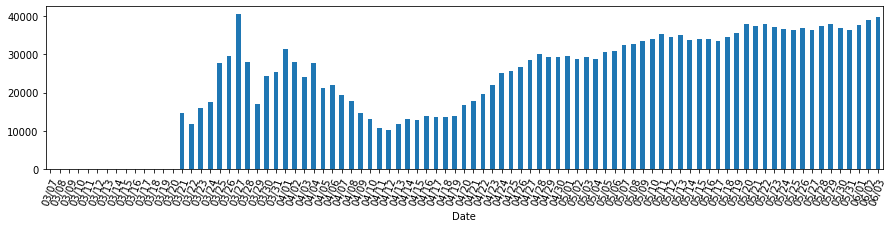

In [23]:
plot_by_time('estimated_total_cases')

It's interesting that the total number of cases actually seems to go down for some period of time.

In [24]:
df['times_doubled_since_ttd'] = infection_to_death_time / df['days_to_double']

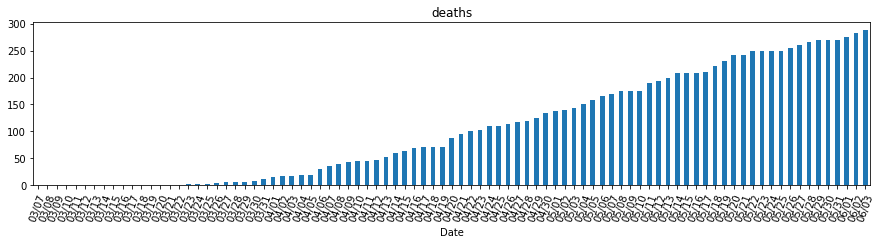

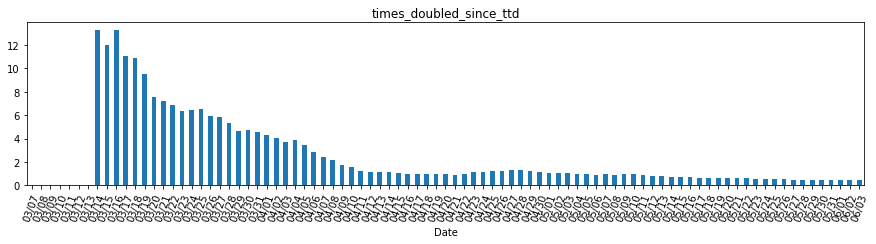

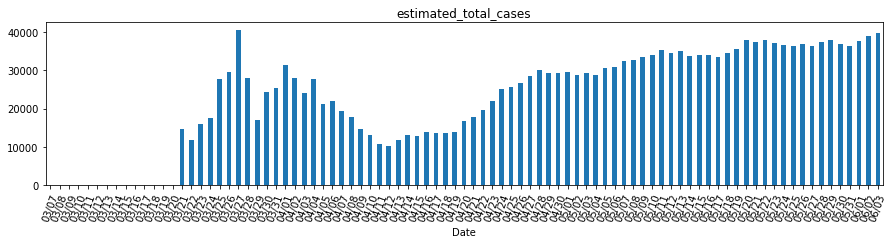

In [25]:
for col in ['deaths', 'times_doubled_since_ttd', 'estimated_total_cases']:
    plt.figure()
    plot_by_time(col)
    plt.title(col)

The interesting shape comes from the fact that the doubling rate has been slowing down. For some time it seems that we were actually beating covid19, but that no longer seems to be the case.

In [26]:
df.estimated_total_cases.fillna(0, inplace=True)
df['estimated_new_cases'] = df['estimated_total_cases'] - df.shift(periods=1)['estimated_total_cases']

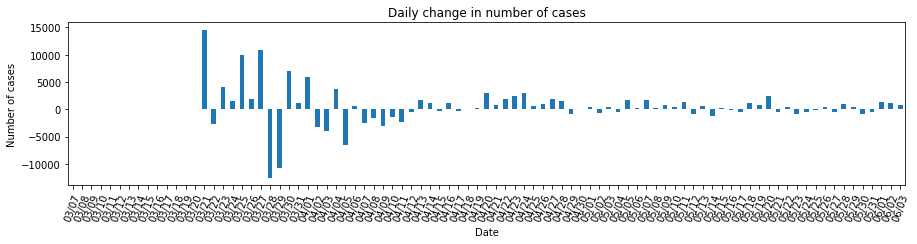

In [27]:
plot_by_time('estimated_new_cases')
plt.title('Daily change in number of cases')
plt.ylabel('Number of cases');

And now let's see how our estimate compares to just the reported cases:

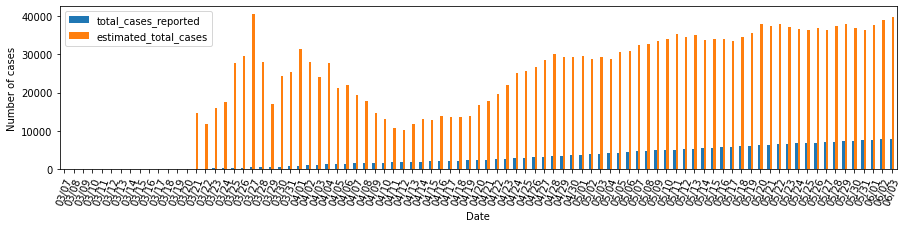

In [28]:
df.set_index('date_str')[['total_cases_reported', 'estimated_total_cases']].plot.bar(figsize=figsize, rot=70)
plt.ylabel('Number of cases')
plt.xlabel('Date');

Even when the estimated cases were decreasing, the reported cases were much lower than our estimate.

And, finally, did we fix the issue of our cases being dependent on test rate?

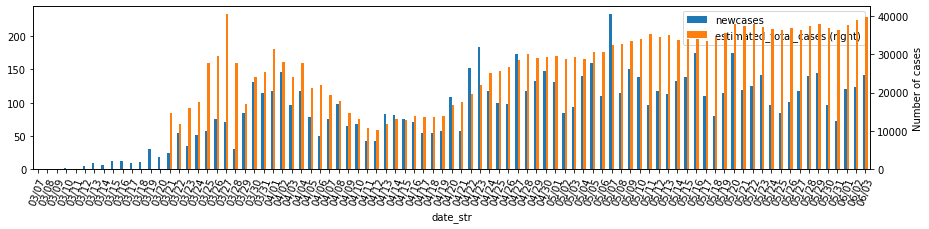

In [29]:
df.set_index('date_str')[['newcases', 'estimated_total_cases']].plot.bar(figsize=figsize, secondary_y= 'estimated_total_cases', rot=70)
plt.ylabel('Number of cases')
plt.xlabel('Date');

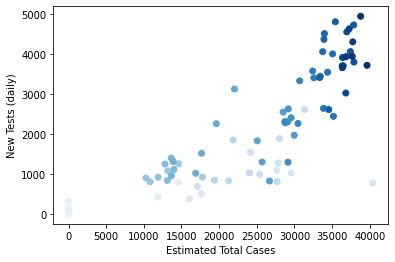

In [30]:
plt.scatter(df['estimated_total_cases'].values, df['newtests'].values, c=df['objectid']/df['objectid'].max(), cmap='Blues')
plt.ylabel('New Tests (daily)')
plt.xlabel('Estimated Total Cases');

In [31]:
df['has_estimate'] = df['estimated_new_cases'].notnull()

In [32]:
stats.spearmanr(df[df['has_estimate']]['estimated_new_cases'].values, 
                df[df['has_estimate']]['newtests'].values)

SpearmanrResult(correlation=0.07479842555294998, pvalue=0.4885544015519343)

In [33]:
stats.spearmanr(df['reported_new_cases'].values, df['newtests'].values)

SpearmanrResult(correlation=0.7932612688243987, pvalue=1.9188092884390598e-20)

Perfect. Now let's double check that this isn't just because we're allowing negative values now:

In [34]:
df['positive_estimate_change'] = df['estimated_new_cases'] > 0

In [35]:
stats.spearmanr(df[df['positive_estimate_change']]['estimated_new_cases'].values, 
                df[df['positive_estimate_change']]['newtests'].values)

SpearmanrResult(correlation=-0.3811285846438483, pvalue=0.008214775816055791)

In [36]:
stats.spearmanr(df['reported_new_cases'].values, df['newtests'].values)

SpearmanrResult(correlation=0.7932612688243987, pvalue=1.9188092884390598e-20)

Even after removing the nonpositive values we only see a small to medium correlation. How about if we check total number of cases?

In [37]:
stats.spearmanr(df['total_cases_reported'].values, df['newtests'].values)

SpearmanrResult(correlation=0.9275549963960786, pvalue=5.9015516421362e-39)

In [38]:
stats.spearmanr(df[df['has_estimate']]['estimated_total_cases'].values, 
                df[df['has_estimate']]['newtests'].values)

SpearmanrResult(correlation=0.8800634565000036, pvalue=1.4853286210092635e-29)

Well this is interesting. The Spearman coefficient seems to make it look like they're nearly as related before. But the difference here is that analytically, we can say that our estimate for number of cases that isn't directly dependent on test rate. There may be correlations and confounds such as the true underlying number of cases, and those could explain the significant correlation.

## Next ideas
Log-log scale new vs total cases
* https://www.youtube.com/watch?v=54XLXg4fYsc